In [3]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
from mirtorch.alg.cg import CG
from mirtorch.linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2d, Gmri
import matplotlib.pyplot as plt
import copy
import h5py
import torchkbnufft as tkbn

## FFT example
First example shows the basic usage of linear operators.
You can use +, -, * like matrices, as long as the size matches.
.H calls the adjoint operatos.

In [4]:
# Assign device
device0 = torch.device('cuda:0')
# Load image
from skimage.data import shepp_logan_phantom
I_shepp = torch.tensor(shepp_logan_phantom()).to(device0)
# Define operator
Fop = FFTCn((400, 400), (400, 400), (0,1), norm = 'ortho')
k_shepp = Fop*I_shepp

show the k-space

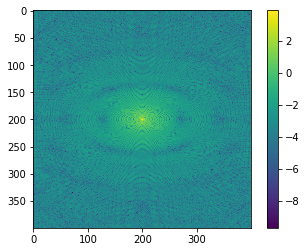

In [5]:
plt.imshow(torch.log(torch.abs(k_shepp)).cpu().data.numpy())
plt.colorbar()

## MRI parallel imaging example (SENSE)
Here we trys a 8-times equidistant 1d undersampling mask.
Both conjugate phase reconstruction (A'y)
and quadratic roughness least-squares reconstruction (argmin(x) \|Ax-y\|_2^2 + \lambda \|Rx\|_2^2) are shown.

Text(0.5, 1.0, 'zero-filled')

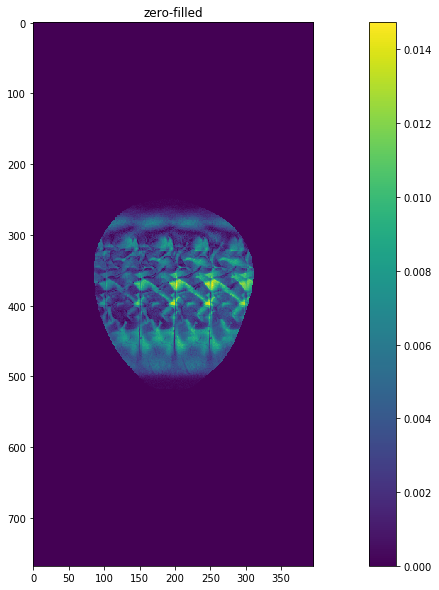

In [6]:
ex_multi = np.load('AXT2_210_6001736_layer11.npz')
device0 = torch.device('cpu')
# k-space
k_c = torch.tensor(ex_multi['k_r'] + 1j*ex_multi['k_i']).to(device0)/32767.0
# Sense map
s_c = torch.tensor(ex_multi['s_r'] + 1j*ex_multi['s_i']).to(device0)/32767.0
# Define Sense operator
(nc, nh, nw) = s_c.shape
Fop = FFTCn((nc, nh, nw), (nc, nh, nw), (1,2), norm = 'ortho')
# Conjugate phase reconstruction
I1 = Fop.H*k_c
I1 = torch.sqrt(I1.abs().pow(2).sum(dim=0))
# Define undersampling mask
mask = torch.zeros(nh,nw)
mask[:,0:nw:8]=1
# Define sense operator
Sop = Sense(s_c, mask, batchmode = False)
# Zero-filled reconstruction
I0 = Sop.H*k_c
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I0).data.numpy())
plt.colorbar()
plt.title('zero-filled')

Define the quadratic roughness penalty, and corresponding CG reconstruction.

In [7]:
T = Diff2d(Sop.size_in, dims = (0,1))
CG_tik = CG(Sop.H*Sop+0.01*T.H*T, max_iter = 40)

residual at 1th iter: 0.06378000895476833
residual at 2th iter: 0.03302536251536047
residual at 3th iter: 0.006197698890693044
residual at 4th iter: 0.004162186760766925
residual at 5th iter: 0.0031184333803622043
residual at 6th iter: 0.00229815898092418
residual at 7th iter: 0.0021860162564000534
residual at 8th iter: 0.0024258260347997046
residual at 9th iter: 0.0008026443151203373
residual at 10th iter: 0.0017281939595664834
residual at 11th iter: 0.0007567341938983128
residual at 12th iter: 0.0004527976116984175
residual at 13th iter: 0.0003733156706118045
residual at 14th iter: 0.00021057463564750622
residual at 15th iter: 0.0002842309832730152
residual at 16th iter: 0.00022170901143448595
residual at 17th iter: 0.00016364660387322027
residual at 18th iter: 0.00012052644638415495
residual at 19th iter: 5.5390897822056416e-05
residual at 20th iter: 4.7889026077467e-05
residual at 21th iter: 4.629553125606578e-05
residual at 22th iter: 5.908192627812196e-05
residual at 23th iter: 6

Text(0.5, 1.0, 'Recovered')

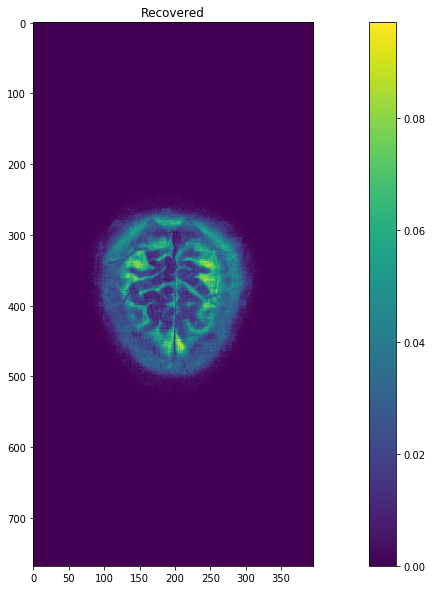

In [8]:
# I0 is both the initialization, and the b in Ax = b.
I_tik = CG_tik.run(I0, I0)
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I_tik).cpu().data.numpy())
plt.colorbar()
plt.title('Recovered')

## Non-Cartesian reconstruction
Here we test a non-Cartesian reconstruction cases.

In [9]:
# Download the files
import wget
url = "https://www.dropbox.com/s/q1cr3u1yyvzjtoj/b0.h5?dl=1"
wget.download(url, './b0.h5')

'./b0 (1).h5'

In [10]:
hf = h5py.File('./b0.h5', 'r')
nx = 320;
ny = 320;
# Load Non-cartesian k-space trajectory
ktraj = hf['ktraj'][()]
ktraj = np.remainder(ktraj + np.pi, 2*np.pi)-np.pi
print('traj shape', ktraj.shape)
# Load k-space
k = hf['k_r'][()] + 1j*hf['k_i'][()]
[ncoil, nslice, nshot, ns] = k.shape
print('k shape', k.shape)
# Load density compensation function
dcf = hf['dcf'][()]
print('dcf shape', dcf.shape)
# Load sensetivity maps
smap = np.transpose(hf['s_r'][()] + 1j*hf['s_i'][()], (3,0,1,2))
smap = np.transpose(smap, (0,1,3,2))
[_, _, nx, ny] = smap.shape
print('smap shape', smap.shape)
# Load fmaps
fmap = hf['b0'][()]
fmap = np.transpose(fmap, (0,2,1))
print('fmap shape', fmap.shape)
# Define 5x retrospective undersampling mask
ktrajunder = ktraj.reshape(2,320,1280)
ktrajunder = ktrajunder[:,0:-1:5,:].reshape(2,81920)
kunder = k[:,:,0:-1:5,:]

traj shape (2, 409600)
k shape (32, 15, 320, 1280)
dcf shape (1, 409600)
smap shape (15, 32, 320, 320)
fmap shape (15, 320, 320)


In [11]:
# Load the numpy file to the pytorch, and define the operator
im_size = (nx,ny)
iz = 6
device0 = torch.device('cuda:0')
k0 = torch.tensor(kunder[:,iz,:,:]).to(device = device0).reshape(1,ncoil,nshot*ns//5)
s0 = torch.tensor(smap[iz,:,:,:]).to(device = device0).unsqueeze(0)
traj0 = torch.tensor(ktrajunder).to(device = device0)
Nop = NuSense(s0, traj0)

In [12]:
# PWLS reconstruction
I0 = Nop.H*k0
T = Diff2d(Nop.size_in, dims = (1,2))
CG_FD = CG(Nop.H*Nop+0.0001*T.H*T, max_iter = 40)
I_FD = CG_FD.run(I0, I0)

residual at 1th iter: 17383129344005.566
residual at 2th iter: 1002671813343.4442
residual at 3th iter: 99343675263.48615
residual at 4th iter: 12192039914.656202
residual at 5th iter: 1442336039.8587432
residual at 6th iter: 279043679.1857637
residual at 7th iter: 94328131.19486162
residual at 8th iter: 45741050.81677665
residual at 9th iter: 40063243.998129874
residual at 10th iter: 23785142.97145201
residual at 11th iter: 9870429.444332313
residual at 12th iter: 8611667.02838599
residual at 13th iter: 12551660.777039861
residual at 14th iter: 5881471.337362152
residual at 15th iter: 4770980.05353378
residual at 16th iter: 2617418.085377391
residual at 17th iter: 1968964.4245425079
residual at 18th iter: 1910345.1688748437
residual at 19th iter: 4222416.843053074
residual at 20th iter: 1236094.2069467995
residual at 21th iter: 926884.967039034
residual at 22th iter: 1297373.9529762003
residual at 23th iter: 1398185.4173690877
residual at 24th iter: 736259.5465812151
residual at 25th 

Text(0.5, 1.0, 'Recovered')

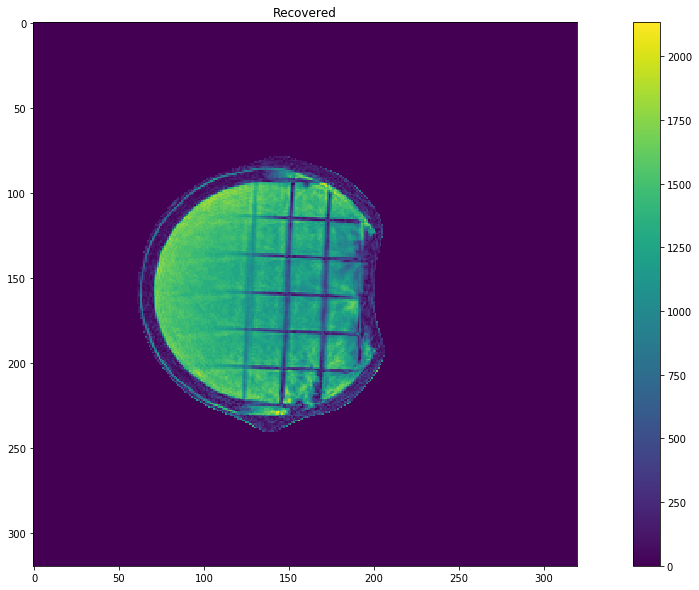

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I_FD.squeeze(0).squeeze(0)).cpu().data.numpy())
plt.colorbar()
plt.title('Recovered')

In [14]:
# Define field-corrected NuSENSE operator
b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
Gop = Gmri(smaps=s0, zmap = -b0, traj = traj0.reshape(2,nshot//5, ns).unsqueeze(0))

In [ ]:
Ib0 = Gop.H*k0.reshape(1,ncoil,nshot//5,ns)
T = Diff2d(Gop.size_in, dims = (1,2))
CG_FD_b0 = CG(Gop.H*Gop+0.0001*T.H*T, max_iter = 40)
I_FD_b0 = CG_FD_b0.run(Ib0, Ib0)

residual at 1th iter: 17402006349877.453
residual at 2th iter: 1003938234884.9994
residual at 3th iter: 99665364125.80493
residual at 4th iter: 12250053977.739475
residual at 5th iter: 1448526140.6031554
residual at 6th iter: 279058529.95569843
residual at 7th iter: 93864323.06897855
residual at 8th iter: 45569660.66596195
residual at 9th iter: 40206003.4501061
residual at 10th iter: 23857439.126830652
residual at 11th iter: 9929927.689728104
residual at 12th iter: 8024628.017443286
residual at 13th iter: 14363518.408336248
residual at 14th iter: 5970374.047920972
residual at 15th iter: 4853454.836886763
residual at 16th iter: 2634990.725326932
residual at 17th iter: 2007962.7778269644
residual at 18th iter: 1893387.4578392527
residual at 19th iter: 4109393.769789476
residual at 20th iter: 1259030.5477820486
residual at 21th iter: 905371.429934921
residual at 22th iter: 836317.0552222484
residual at 23th iter: 2965764.761901799
residual at 24th iter: 704755.3794027839
residual at 25th 

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I_FD_b0[0]).cpu().data.numpy())
plt.colorbar()
plt.title('B0-informed reconstruction')